<a href="https://colab.research.google.com/github/nishkarsh25/Know_your_Habitat/blob/main/mandiLens.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **mandiLens**
###### Find what you're looking at.
---
#### **Project Documentation & Code**

# **Creating our CNN Model**
Mounting the Google Drive to access our dataset.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Setting variables containing path to training and testing dataset.

In [ ]:
import os
datapath = os.getcwd() + '/gdrive/MyDrive/dataset/'

In [ ]:
from tensorflow import keras

In [ ]:
train_path = datapath + 'training/'

test_path = datapath + 'testing/'

In [ ]:
batch_size = 16

Given the directory with folders as class labels, Keras has ability to auto-generate the dataset from the directory. While doing so, Keras also has the ability to resize the input images according to need.
We specify a seed so that we can separately generate training and testing dataset.

In [ ]:
train_ds = keras.utils.image_dataset_from_directory(
    directory= datapath+'training/',
    labels='inferred',
    label_mode='categorical',
    batch_size=8,
    shuffle=True,
    seed=121,
    subset='training',
    validation_split=0.3,
    image_size=(299, 299))

valid_ds = keras.utils.image_dataset_from_directory(
    directory= datapath+'training/',
    labels='inferred',
    label_mode='categorical',
    batch_size=8,
    shuffle=True,
    seed=121,
    subset='validation',
    validation_split=0.3,
    image_size=(299, 299))

Found 297 files belonging to 8 classes.
Using 208 files for training.
Found 297 files belonging to 8 classes.
Using 89 files for validation.


In [ ]:
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model, load_model

Since our dataset is on smaller side, and we do not have access to high end CUDA Cores, we choose to train our model using transfer learning. We choose VGG19, a pre-built 19-layered Deep Neural Network, which has already been pre-trained on imagenet dataset. Since imagenet dataset also includes buildings in its classification and feature extraction (same as our problem statement), we remove the classification layers from VGG19, and add layers with Neurons Count same as our classes as output layer.

Also, we use VGG19 with pre-trained weights, and mark these layers as 'non-trainable', meaning that these preset weights will not change during training.

In [ ]:
vgg = VGG19(
    input_shape=(299, 299, 3),
    weights='imagenet', 
    include_top=False
    )

vgg.trainable = False
# flatten the max-pooling output of VGG
flatten = vgg.output
flatten = Flatten()(flatten)
# construct a fully-connected layer header to output the predicted
output = Dense(8, activation="softmax")(flatten)
# construct the model we will fine-tune for bounding box regression
model = Model(inputs=vgg.input, outputs=output)

In [ ]:
model.summary()

Now that our model is made, we train it on our data, in 10 epochs.

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(train_ds, validation_data=valid_ds, epochs=10, batch_size=batch_size)

Epoch 1/10
26/26 [==============================] - 19s 575ms/step - loss: 11.8399 - accuracy: 0.7019 - val_loss: 1.5571 - val_accuracy: 0.9101
Epoch 2/10
26/26 [==============================] - 18s 568ms/step - loss: 1.6260 - accuracy: 0.9471 - val_loss: 1.9425 - val_accuracy: 0.8989
Epoch 3/10
26/26 [==============================] - 18s 571ms/step - loss: 0.3740 - accuracy: 0.9856 - val_loss: 3.1146 - val_accuracy: 0.9213
Epoch 4/10
26/26 [==============================] - 18s 565ms/step - loss: 7.4506e-09 - accuracy: 1.0000 - val_loss: 1.1114 - val_accuracy: 0.9438
Epoch 5/10
26/26 [==============================] - 18s 571ms/step - loss: 4.0118e-09 - accuracy: 1.0000 - val_loss: 1.1095 - val_accuracy: 0.9438
Epoch 6/10
26/26 [==============================] - 20s 646ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 1.1088 - val_accuracy: 0.9438
Epoch 7/10
26/26 [==============================] - 18s 569ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 1.1088 - val

We create our testing dataset from directory.

In [ ]:
test_ds = keras.utils.image_dataset_from_directory(
    directory= datapath+'testing/',
    labels='inferred',
    label_mode='categorical',
    batch_size=8,
    shuffle=True,
    image_size=(299, 299))

Found 34 files belonging to 8 classes.


Since we need to give labels during prediction, and the Keras dataset uses one-hot encoding for categories, we manually need to set the labels corresponding to each one-hot enoding, which is done as follows. Keras creates one-hot encoding in ascending order of label names.

In [ ]:
import os

labels = os.listdir(datapath+'testing/')
labels = sorted(labels)

Evaluating the model, we get a very nice accuracy of 97.06%.

In [ ]:
results = model.evaluate(test_ds, batch_size=1)
print(results)

5/5 [==============================] - 8s 308ms/step - loss: 3.1273 - accuracy: 0.9706
[3.1273274421691895, 0.970588207244873]


If one chooses to custom-train the model, they can save their model as follows,

In [ ]:
model.save(datapath+"model.h5")

# **Importing Saved Model**
In case we wish to use a pre-saved model for the same, we can load the same by running the cell below.

In [ ]:
!wget https://github.com/bhuvannarula/mandiLens/raw/main/savedModels/model.h5

--2022-12-04 16:59:30--  https://github.com/bhuvannarula/mandiLens/raw/main/savedModels/model.h5
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/bhuvannarula/mandiLens/main/savedModels/model.h5 [following]
--2022-12-04 16:59:31--  https://raw.githubusercontent.com/bhuvannarula/mandiLens/main/savedModels/model.h5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84171080 (80M) [application/octet-stream]
Saving to: ‘model.h5’

model.h5            100%[===================>]  80.27M   398MB/s    in 0.2s    

2022-12-04 16:59:31 (398 MB/s) - ‘model.h5’ saved [84171080/84171080]



In [ ]:
model = load_model('model.h5')

# **Sample Predictions**
Some sample images, to showcase the prediction of our model.

In [ ]:
from keras.utils import load_img
from keras.utils import img_to_array
import numpy as np
t_img = test_path + 'OAK/20221125_143623.jpg'
#t_img = test_path + 'A9/20221125_141501.jpg'

First, We show the image we are using,

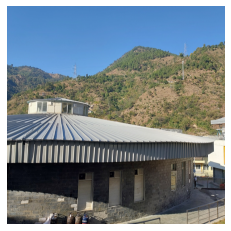

In [ ]:
from PIL import Image
from matplotlib import pyplot as plt

img = Image.open(t_img)
img = img.rotate(270)
plt.axis("off")
plt.imshow(img)

Then, we predict the label for the same image as follows,

In [ ]:
imgin = load_img(
    t_img,
    color_mode='rgb',
    target_size=(299,299,3)
)
input_arr = img_to_array(imgin)
input_arr = np.array([input_arr])  # Convert single image to a batch.
predictions = model.predict(input_arr)
y_classes = predictions.argmax(axis=-1)
print("Predicted Class:", labels[y_classes[0]])

1/1 [==============================] - 0s 20ms/step
Predicted Class: OAK


# **Predicting on Custom-Image**
User can upload their image using the following,

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving IMG_20221125_141123_test.jpg to IMG_20221125_141123_test.jpg


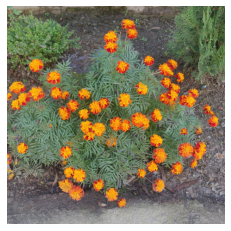

In [ ]:
t_img = list(uploaded.keys())[0]
img = Image.open(t_img)
plt.axis("off")
plt.imshow(img)

In [ ]:
imgin = load_img(
    t_img,
    color_mode='rgb',
    target_size=(299,299,3)
)
input_arr = img_to_array(imgin)
input_arr = np.array([input_arr])  # Convert single image to a batch.
predictions = model.predict(input_arr)
y_classes = predictions.argmax(axis=-1)
print("Predicted Class:", labels[y_classes[0]])